In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'RL.csv'
fr = pd.read_csv(FILE)

V = np.array(fr['VR (mV)'])* 10**-3
t = np.array(fr['t(us)']) * 10**-6

R = 996 # misurata con multimetro
R_L = 58.5 # resistenza interna all'induttanza misurata dal multimetro
sigmaR_L = 0.1 # ohm
sigmaR = 1 # ohm
T = 0.05 # s impostato sull'oscilloscopio, valutare se rimuovere
sigmaV = 0.2 /np.sqrt(12)

$
V_R(t) = R\frac{V_g}{R+R_L} \left(1 - \frac{2 \cdot e^{-\frac{t}{\tau}}}{1 + e^{-\frac{T}{2\tau}}}\right) 
$

where $\tau = \frac{L}{R + R_L}$

In [2]:
def VR(t,τ,Vg):
    RRL = R + R_L
    # τ = L/RRL
    return (R*(Vg/RRL)) *(1- 2*np.exp(-t/τ)/(1+np.exp(-T/(2*τ))))

In [3]:
L_guess = 0.082 # Hr
Vg_guess = 1.984 # V
RL_guess = 58.5 # ohm


iVR = Interpolazione(t,V,VR,sigmaV,p0=[L_guess/R,Vg_guess])
print(iVR)

# dala tensione misurata su VR calcoliamo la corrente passante nell'induttanza
It = iVR.y_best/R # V = RI, calcolo corrente passante nel circuito (e quindi anche nell'induttanza)

print('----------------------- RESULT -----------------------')

τ = iVR.bval[0]
sigmaτ = iVR.sigma_bval[0]

VRmax = R*iVR.bval[1]/ (R+R_L)
sigmaVRmax = iVR.sigma_bval[1]

VRLmax = R_L*iVR.bval[1]/ (R+R_L)
sigmaVRLmax = iVR.sigma_bval[1]

L = τ * (R_L + R)
sigmaRtot = np.sqrt(sigmaR**2 + sigmaR_L**2)
sigmaL = np.sqrt((R_L + R)**2 * sigmaτ**2 + τ**2 * sigmaRtot**2)

# Calcolo tensione in R_L: I(t) = V_L/R_L*(exp...) -> V_L = I(t)*R_L in particolare in t = 0:
Vg = VRLmax + VRmax
sigmaVg = np.sqrt(sigmaVRLmax**2 + sigmaVRmax**2)

print('L =',final_val(L,sigmaL,decimals=1,exp=-3,udm='Hr')) # TODO: valutare numero di decimali significativi
print('V_Rmax = ',final_val(VRmax,sigmaVRmax,decimals=3,udm='V')) # misurata sperimentale
print('V_RLmax = ',final_val(VRLmax,sigmaVRLmax,decimals=4,udm='V'))
print('Vg = ', final_val(Vg,sigmaVg,decimals=3,udm='V'))

   
Parameters: [8.42516517e-05 1.92439428e+00] 
Sigma parameters: [2.80459960e-07 4.91352209e-03]

sigmaY: 0.05773502691896258

chiquadro ridotto: 0.12
df: 53
pvalue: 100.0%
covariance matrix: [[7.30412330e-14 5.22279014e-10]
 [5.22279014e-10 2.24187909e-05]]    

----------------------- RESULT -----------------------
L = (88.8 ± 0.3)e-3 Hr
V_Rmax =  1.818 ± 0.005 V
V_RLmax =  0.1068 ± 0.0049 V
Vg =  1.924 ± 0.007 V


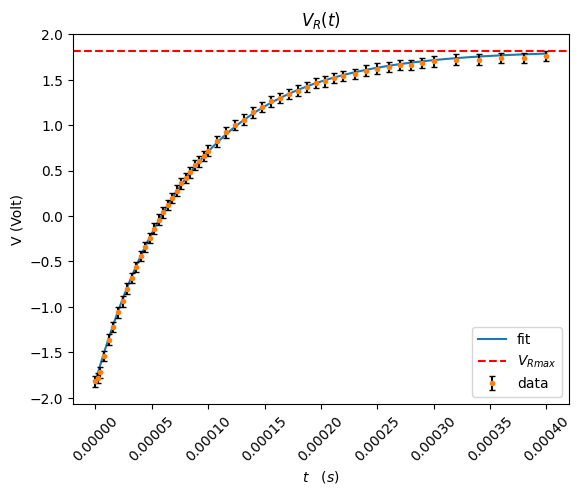

In [4]:
plt.plot(iVR.x_best, iVR.y_best, label='fit')
plt.errorbar(t, V, yerr=sigmaV, ecolor='black', fmt='.', label='data',capsize=2)
plt.axhline(VRmax, color='red', linestyle='--', label='$V_{Rmax}$')
plt.xlabel('$t \quad (s)$')
plt.ylabel('V (Volt)')
plt.legend()
plt.title('$V_R(t)$')
plt.xticks(rotation=45)
plt.show()

# DOMANDE


1. L’induttanza L ha anche una sua propria resistenza, va considerata? Quanto `e
importante nelle vostre misure?

L'induttanza reale ha una resistenza interna, nel nostro caso è stata misurata con l'ohmmetro ed il suo valore è di $58.5\Omega$.

Sperimentalmente abbiamo misurato i valori di tensione ai capi di R, il fit resistuisce una costante VgVL che rappresenta la tensione del generatore se $R_L$ fosse assente. Dato che $V_g = V_L + V_R$ e conoscendo I(t) possiamo stimare $V_g$:

$I_{max} = \frac{V_{Rmax}}{R} \Rightarrow V_L = R_L \cdot I$

Riportando i valori trovati:
- V_Rmax =  1.818 ± 0.005 V
- V_L =  0.1068 ± 0.0002 V
- Vg =  1.924 ± 0.005 V

QUINDI: nella nostra configurazione degli strumenti la presenza di $R_L$ non influisce sulla stima di $L$ ma sul valore di $V_g$

## PLOT ALL V-I CHARACTERISTICS

$
V_R(t) = R\frac{V_g}{R+R_L} \left(1 - \frac{2 \cdot e^{-\frac{t}{\tau}}}{1 + e^{-\frac{T}{2\tau}}}\right) 
$

$
V_{R_L}(t) = R_L\frac{V_g}{R+R_L} \left(1 - \frac{2 \cdot e^{-\frac{t}{\tau}}}{1 + e^{-\frac{T}{2\tau}}}\right) 
$

$
I(t) = V_g \left(1 - \frac{2 \cdot e^{-\frac{t}{\tau}}}{1 + e^{-\frac{T}{2\tau}}}\right) 
$

$
V_L(t) = L\dot{I} = 2V_g \frac{2 \cdot e^{-\frac{t}{\tau}}}{1 + e^{-\frac{T}{2\tau}}}
$

In [13]:
def I(t):
    return Vg/(R_L + R) * (1 - 2*np.exp(-t/τ)/(1+np.exp(-T/(2*τ))))

def V_RL(t):
    return I(t)*R_L

def V_R(t):
    return I(t)*R

def V_L(t):
    return (- I(t) + Vg/(R+R_L))*Vg

/tmp/ipykernel_11211/4282092719.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(np.round(t,6),rotation=45)
/tmp/ipykernel_11211/4282092719.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(np.round(t,6),rotation=45)
/tmp/ipykernel_11211/4282092719.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_xticklabels(np.round(t,6),rotation=45)
/tmp/ipykernel_11211/4282092719.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(np.round(t,6),rotation=45)


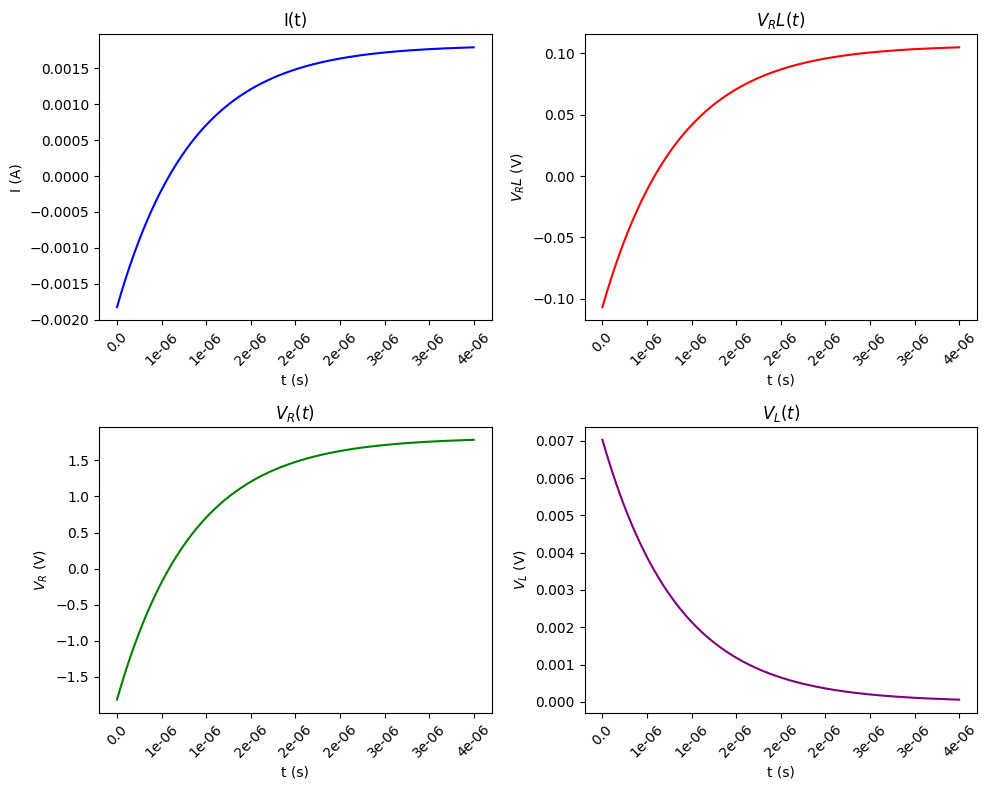

In [29]:
# Plot all V-I characteristics
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot I vs t
axs[0, 0].plot(t, I(t), color='blue')
axs[0, 0].set_xlabel('t (s)')
axs[0, 0].set_ylabel('I (A)')
axs[0, 0].set_title('I(t)')
axs[0, 0].set_xticklabels(np.round(t,6),rotation=45)

# Plot V_RL vs t
axs[0, 1].plot(t, V_RL(t), color='red')
axs[0, 1].set_xlabel('t (s)')
axs[0, 1].set_ylabel('$V_RL$ (V)')
axs[0, 1].set_title('$V_RL(t)$')
axs[0, 1].set_xticklabels(np.round(t,6),rotation=45)

# Plot V_R vs t
axs[1, 0].plot(t, V_R(t), color='green')
axs[1, 0].set_xlabel('t (s)')
axs[1, 0].set_ylabel('$V_R$ (V)')
axs[1, 0].set_title('$V_R(t)$')
axs[1, 0].set_xticklabels(np.round(t,6),rotation=45)

# Plot V_L vs t
axs[1, 1].plot(t, V_L(t), color='purple')
axs[1, 1].set_xlabel('t (s)')
axs[1, 1].set_ylabel('$V_L$ (V)')
axs[1, 1].set_title('$V_L(t)$')
axs[1, 1].set_xticklabels(np.round(t,6),rotation=45)

plt.tight_layout()

# Rotate xticks by 45 degrees

plt.show()


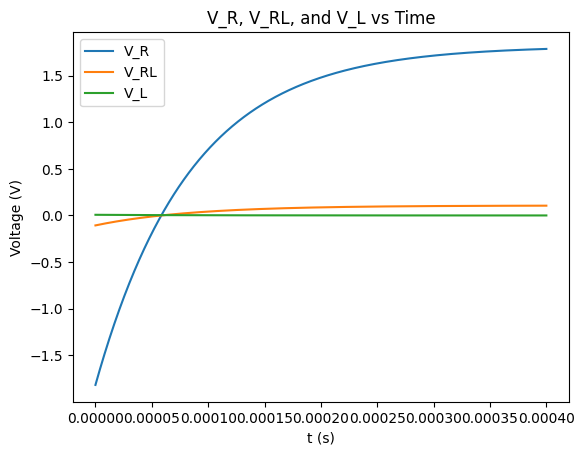

In [15]:
plt.plot(t, V_R(t), label='V_R')
plt.plot(t, V_RL(t), label='V_RL')
plt.plot(t, V_L(t), label='V_L')
plt.xlabel('t (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.title('V_R, V_RL, and V_L vs Time')
plt.show()
